In [1]:
import numpy as np 
import pickle

In [5]:
!pwd

/n/home12/binxuwang/Github/DiffusionReasoning/notebooks


In [2]:
rule_dir = '/n/home12/binxuwang/Github/DiffusionReasoning/rule_data/'

# attr_all = np.load(data_dir+'attr_all.npy') # (40, 12000, 3, 9, 3), (num_rules, num_samples, num_panels, num_pos, num_attributes)

with open(rule_dir+'r_dict_M7_withR.pkl', 'rb') as file:
    r_dict_M7_withR = pickle.load(file)
    
with open(rule_dir+'r_dict_M10_withR.pkl', 'rb') as file:
    r_dict_M10_withR = pickle.load(file)
    
with open(rule_dir+'r_dict_num_withR.pkl', 'rb') as file:
    r_dict_num_withR = pickle.load(file)
    
with open(rule_dir+'r_dict_pos_withR.pkl', 'rb') as file:
    r_dict_pos_withR = pickle.load(file)

In [3]:
def get_key_first2(a_list):
    """
    convert a_list to key string
    e.g., a_list = [[1,2], [1]], key='12-1'
    """
    key = ''
    for x in a_list[0]: 
        key+=str(x)
    key += '-'
    for x in a_list[1]: 
        key+=str(x) 
    return key

def get_attr(attr): 
    """attr.shape # (num_panels, num_obs, obj)"""
    # step 1: check number of objects 
    x_num = [[] for i in range(3)]
    x_pos = [[] for i in range(3)]
    x_shape = [[] for i in range(3)]
    x_color = [[] for i in range(3)]
    x_size = [[] for i in range(3)]

    for i, attr_panel in enumerate(attr): 

        pos = list(np.where((attr_panel==-1).sum(1)==0)[0])
        x_pos[i] = pos 
        x_num[i] = [len(pos)]
        x_shape[i] = list(np.unique(attr_panel[pos,0]))
        x_color[i] = list(np.unique(attr_panel[pos,1]))
        x_size[i] = list(np.unique(attr_panel[pos,2]))
        
    return x_num, x_pos, x_shape, x_color, x_size 

def check_rule(x, r_dict_withR): 
    i_R = None
    key_first2 = get_key_first2(x) # '5-5'
    if key_first2 in r_dict_withR.keys(): 
        d = r_dict_withR[key_first2]
        if x[2] in d.values():
            i_R = list(d.keys())[list(d.values()).index(x[2])]
    return i_R 

def check_row_rule(attr): 
    """attr: (3, 9, 3), return list of rule """
    x_num, x_pos, x_shape, x_color, x_size = get_attr(attr)
    
    rule_list = []
    R_shape = check_rule(x_shape, r_dict_M7_withR)
    if R_shape is not None: 
        rule_list.append(R_shape)

    R_color = check_rule(x_color, r_dict_M10_withR)
    if R_color is not None: 
        rule_list.append(R_color+10)

    R_size = check_rule(x_size, r_dict_M10_withR)
    if R_size is not None: 
        rule_list.append(R_size+20)
        
    R_num = check_rule(x_num, r_dict_num_withR)
    if R_num is not None: 
        rule_list.append(R_num+30)
        
    R_pos = check_rule(x_pos, r_dict_pos_withR)
    if R_pos is not None: 
        rule_list.append(R_pos+37)
        
    return np.asarray(rule_list)

### Test rule checking on training data

In [4]:
data_dir = '/n/home12/binxuwang/Github/DiffusionReasoning/'

attr_all = np.load(data_dir+'attr_all.npy')

In [5]:
attr_all.shape

(40, 12000, 3, 9, 3)

In [6]:
from tqdm import trange, tqdm
for i_rule in trange(40): 
    for i in trange(12000):
        attr = attr_all[i_rule, i]
        rule_list = check_row_rule(attr)
        assert len(rule_list) == 1 # uniqueness 
        assert rule_list[0] == i_rule # correctness

100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


### Build and save new train inputs

In [30]:
import torch
excluded_rules = [1, 16, 20, 34, 37]
included_rules = [i for i in range(40) if i not in excluded_rules]
train_attrs_all = attr_all[included_rules,:]
train_attrs_all = torch.from_numpy(train_attrs_all).to(torch.int32)
assert train_attrs_all.shape == (35, 12000, 3, 9, 3)
torch.save(train_attrs_all, data_dir+'train_inputs_new.pt')

### Build new sets of training data

In [7]:
import torch
gen_id_list = [
    [1, 16, 20, 34, 37], 
    [8, 12, 24, 36, 39],
    [5, 17, 21, 33, 38],
    [3, 10, 29, 31, 37],
    [0, 14, 27, 35, 38],
    [4, 19, 26, 30, 39],
    [9, 13, 25, 32, 37],
    [2, 18, 23, 30, 38],
    [7, 15, 22, 34, 39],
    [6, 11, 28, 33, 37],
]
# excluded_rules = [1, 16, 20, 34, 37]
for i_split, excluded_rules in tqdm(enumerate(gen_id_list)): 
    included_rules = [i for i in range(40) if i not in excluded_rules]
    train_attrs_all = attr_all[included_rules,:]
    train_attrs_all = torch.from_numpy(train_attrs_all).to(torch.int32)
    assert train_attrs_all.shape == (35, 12000, 3, 9, 3)
    torch.save(train_attrs_all, data_dir+f'train_inputs_new_split{i_split}.pt')

10it [00:13,  1.39s/it]


In [1]:
import json
from os.path import join
expdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/080-RAVEN10_abstract-uncond-DiT_S_1_20240401-0244"

args = json.load(open(join(expdir, 'args.json')))

In [3]:
args['train_attr_fn']

'train_inputs_new_split5.pt'

In [31]:
train_attrs_all = torch.load(data_dir+'train_inputs_new.pt')

In [32]:
train_attrs_all.dtype

torch.int32

In [22]:
torch.from_numpy(train_attrs_all).to(torch.int32)

torch.int64

In [26]:
(train_attrs_all - torch.tensor(0.5)).dtype

torch.float32

In [28]:
torch.allclose((train_attrs_all.to(torch.float) - torch.tensor(0.5)), 
               (train_attrs_all - torch.tensor(0.5)))

True

In [45]:
from collections import defaultdict
def check_rule_overlap(attr_list): 
    """
    Inputs: 
        attr_list: (3, 3, 9, 3), (3 rows, 3 panels, 9 pos, 3 attr)
    Outputs: 
        r3: list of rules appearing in all 3 rows 
        r2: list of rules appear in only 2 of the 3 rows 
    """
    rule_all = [check_row_rule(a) for a in attr_list] # rule_list for each row, e.g., [[0,1], [0,1], [0,2]]
    
    r_dict = defaultdict(int) # e.g., {0: 3, 1: 2, 2: 1}, key=rule_ind, value=number of occurance in 3 rows
    for rule in rule_all:
        for x in rule: 
            if x not in r_dict.keys(): 
                r_dict[x] = 0 
            r_dict[x] += 1 

    r3, r2 = [], []
    for k, v in r_dict.items():
        if v == 3:
            r3.append(k)
        elif v == 2:
            r2.append(k)
    
    return r3, r2, rule_all

def check_r3_r2_batch(attr_sample): 
    """
    Inputs: 
        attr_sample: e.g., (4000, 3, 3, 9, 3), (num_samples, 3 rows, 3 panels, 9 pos, 3 attrs)
    Outputs: 
        r3_all: list, rule that appear in all 3 rows for each sample 
        r2_all: list, rule that appear in 2 of 3 rows 
        
    TODO: multiple CPU cores? concurrent.futures
    """
    r3_all = []
    r2_all = []
    rule_collector = []
    for attr_list in attr_sample: 
        r3, r2, rule_all = check_rule_overlap(attr_list)

        r3_all.append(r3)
        r2_all.append(r2)
        rule_collector.append(rule_all)
        
    return r3_all, r2_all, rule_collector

In [3]:
sample_dir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256/samples"

In [61]:
import os
from os.path import join
import sys
import torch
sys.path.append("../")
from dataset_utils import onehot2attr_tsr

def batch_load_samples(samples_dir, epoch_list, encoding="onehot", fmt="tensor%s.pt"):
    sample_all = []
    for epoch in tqdm(epoch_list): 
        if not os.path.exists(join(samples_dir, fmt % epoch)):
            print(epoch, "not exist")
            break
        samples = torch.load(join(samples_dir, fmt % epoch)) # (batch, 27, 9, 9)
        if encoding == "onehot":
            attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
        elif encoding == "digit":
            attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
        else:
            raise ValueError("encoding should be onehot or digit")
        sample_all.append(attr_tsr_list)
    epoch_list = epoch_list[:len(sample_all)]
    return sample_all, epoch_list

In [63]:
import einops
import pandas as pd

def samples_infer_rule_consistency(sample_all, epoch_list, ):
    stats_col = []
    rule_list_all = []
    consistency_all = []
    pbar = tqdm(enumerate(epoch_list))
    for i, epoch in pbar: 
        # print(i, epoch)
        batchsize = sample_all[i].shape[0]
        sample_batch = sample_all[i] # [1024, 3, 9, 9]
        sample_batch = sample_batch.view(-1, 3, 3, 3, 9) 
        sample_batch = einops.rearrange(sample_batch, 
                "B attr row h (panel w) -> B row panel (h w) attr", 
                                    panel=3, w=3, h=3, attr=3)
        r3_list, r2_list, rule_col = check_r3_r2_batch(sample_batch)
        r3_count = sum([len(x) > 0 for x in r3_list])
        r2_count = sum([len(x) > 0 for x in r2_list])
        rule_flatten = np.array(rule_col).flatten() # [3 * 1024]
        anyvalid_count = sum([len(x) > 0 for x in rule_flatten])
        stats_col.append({"epoch": epoch, "r3_count": r3_count, "r2_count": r2_count, 
                        "valid_count": anyvalid_count, "sample_count": batchsize})
        rule_list_all.append((rule_col))
        consistency_all.append((r3_list, r2_list))
        pbar.set_postfix({"epoch": epoch, "r3_count": r3_count, "r2_count": r2_count})

    stats_df = pd.DataFrame(stats_col)
    return stats_df, rule_list_all, consistency_all

In [62]:
sample_all, epoch_list = batch_load_samples(sample_dir, [1]+[*range(1000, 334000, 1000)], encoding="digit", fmt="%07d.pt")
# sample_all = batch_load_samples(sample_dir, [1000], encoding="digit", fmt="%07d.pt")

100%|██████████| 334/334 [00:01<00:00, 321.06it/s]


In [78]:

import matplotlib.pyplot as plt
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error
def visualize_consistency_new(stats_df, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.r3_count, stats_df.sample_count, alpha=0.05)
    shaded_error(plt.gca(), stats_df.epoch, stats_df.r3_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI(stats_df.r2_count, stats_df.sample_count, alpha=0.05)
    shaded_error(plt.gca(), stats_df.epoch, stats_df.r2_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    if figdir is not None:
        fig.savefig(join(figdir, f"{figname}_new_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
        fig.savefig(join(figdir, f"{figname}_new_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return fig
    
    
def visualize_rule_validity_new(stats_df, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    row_num = 3
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.valid_count, 
                                  stats_df.sample_count * row_num, alpha=0.05)
    shaded_error(plt.gca(), stats_df.epoch, stats_df.valid_count / stats_df.sample_count / row_num,
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    if figdir is not None:
        fig.savefig(join(figdir,f"{figname}_new_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
        fig.savefig(join(figdir,f"{figname}_new_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return fig

100%|██████████| 20/20 [00:00<00:00, 565.26it/s]
0it [00:00, ?it/s]/tmp/ipykernel_2895151/1894043866.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rule_flatten = np.array(rule_col).flatten() # [3 * 1024]
20it [00:23,  1.18s/it, epoch=19000, r3_count=1, r2_count=66]
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


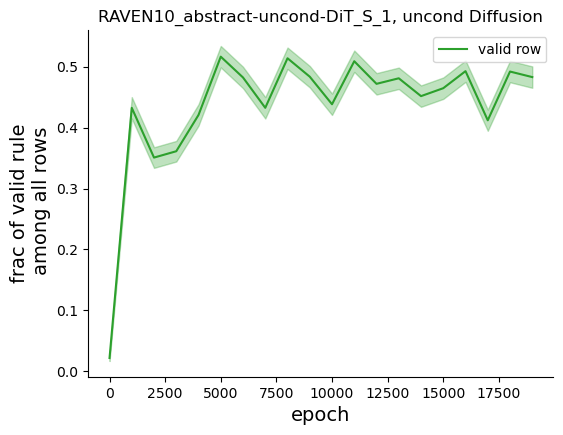

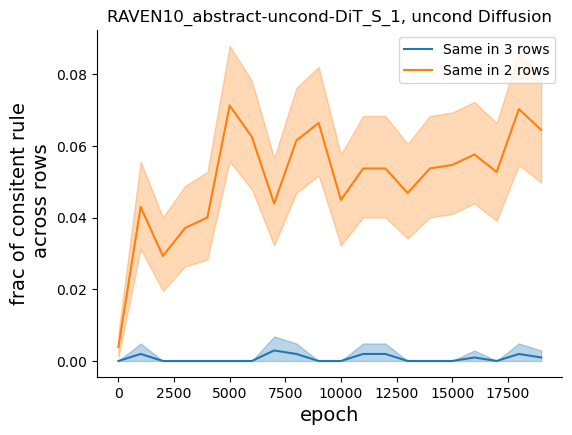

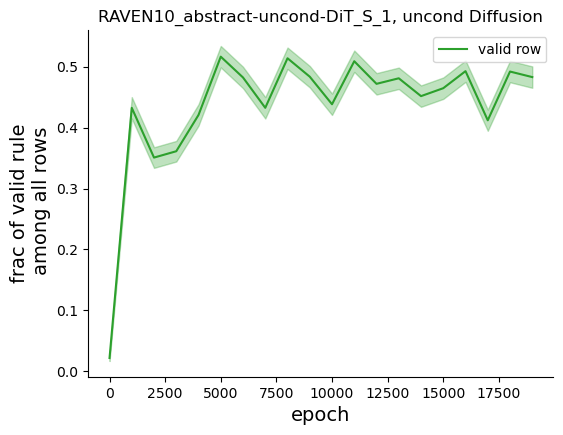

In [79]:
expdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
samples_dir = join(expdir, "samples")
sample_all, epoch_list = batch_load_samples(sample_dir, [1]+[*range(1000, 20000, 1000)], encoding="digit", fmt="%07d.pt")
stats_df, rule_list_all, consistency_all = samples_infer_rule_consistency(sample_all, epoch_list)
stats_df.to_csv(join(sample_dir, "..", "consistency_new_stats_df.csv"))
np.savez(join(expdir, "samples_inferred_rule_consistency_new.npz"), 
            consistency_all=consistency_all, 
            rule_list_all=rule_list_all, epoch_list=epoch_list)
visualize_consistency_new(stats_df, title_str="RAVEN10_abstract-uncond-DiT_S_1", 
                          figname="RAVEN10_abstract-uncond-DiT_S_1", figdir=None)
visualize_rule_validity_new(stats_df, title_str="RAVEN10_abstract-uncond-DiT_S_1",
                            figname="RAVEN10_abstract-uncond-DiT_S_1", figdir=None)

In [88]:
data = np.load(join(expdir, "samples_inferred_rule_consistency_new.npz"), allow_pickle=True)
consistency_all_load = data["consistency_all"]
rule_list_all_load = data["rule_list_all"]
epoch_list_load = data["epoch_list"]

In [96]:
epoch_list = [*range(1000, 30000, 1000)]
if os.path.exists(join(expdir, "samples_inferred_rule_consistency_new.npz")):# and args.update:
    print("Inferred rules already exist. Loading from file.")
    npzfile = np.load(join(expdir, "samples_inferred_rule_consistency_new.npz"), allow_pickle=True)
    stats_df_load = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"),)
    consistency_all_load = npzfile["consistency_all"]
    rule_list_all_load = npzfile["rule_list_all"]
    epoch_list_load = npzfile["epoch_list"]
    epoch_rest = [epoch for epoch in epoch_list if epoch not in epoch_list_load]
    print(rule_list_all_load.shape, consistency_all_load.shape, len(epoch_rest))
    print("Updating inferred rules, starting from epoch: ", epoch_rest[0])
    sample_all, epoch_rest = batch_load_samples(join(expdir, "samples"), 
                        epoch_rest, encoding="digit", fmt="%07d.pt")
    stats_df_rest, rule_list_all_rest, consistency_all_rest = samples_infer_rule_consistency(
                        sample_all, epoch_rest)

    # rules_all_rest, consistent_mat_rest, epoch_rest = batch_load_samples_infer_rules(
    #     join(expdir, "samples"), epoch_rest, encoding=encoding, fmt=args.fmt)
    if len(epoch_rest) == 0 and len(sample_all) == 0:
        consistency_all, rule_list_all, epoch_list = consistency_all_load, rule_list_all_load, epoch_list_load
        stats_df = stats_df_load
    else:
        rule_list_all_rest = np.array(rule_list_all_rest, dtype=object)
        consistency_all_rest = np.array(consistency_all_rest, dtype=object)
        rule_list_all = np.concatenate([rule_list_all_load, rule_list_all_rest], axis=0)
        consistency_all = np.concatenate([consistency_all_load, consistency_all_rest], axis=0)
        epoch_list = np.concatenate([epoch_list_load, epoch_rest], axis=0)
        print("Inferred rules updated.")
    # print(rules_al

Inferred rules already exist. Loading from file.
(20, 1024, 3) (20, 2, 1024) 10
Updating inferred rules, starting from epoch:  20000


100%|██████████| 10/10 [00:00<00:00, 644.15it/s]
0it [00:00, ?it/s]/tmp/ipykernel_2895151/1894043866.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rule_flatten = np.array(rule_col).flatten() # [3 * 1024]
10it [00:14,  1.42s/it, epoch=29000, r3_count=3, r2_count=83]

Inferred rules updated.


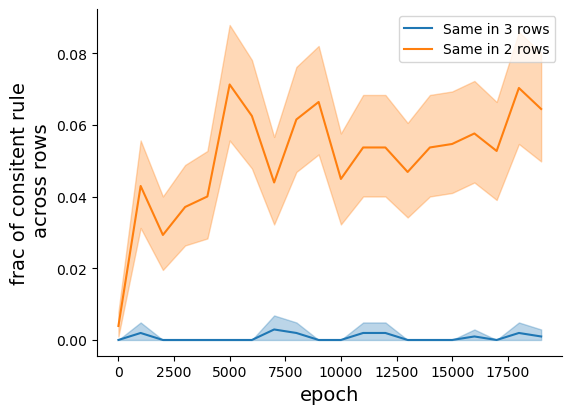

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI(stats_df.r3_count, stats_df.sample_count, alpha=0.05)
shaded_error(plt.gca(), stats_df.epoch, stats_df.r3_count / stats_df.sample_count,
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI(stats_df.r2_count, stats_df.sample_count, alpha=0.05)
shaded_error(plt.gca(), stats_df.epoch, stats_df.r2_count / stats_df.sample_count,
                CI_low, CI_high, label="Same in 2 rows", color="C1")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
# ax.set_title(f"{title_str}, uncond Diffusion")
ax.legend()

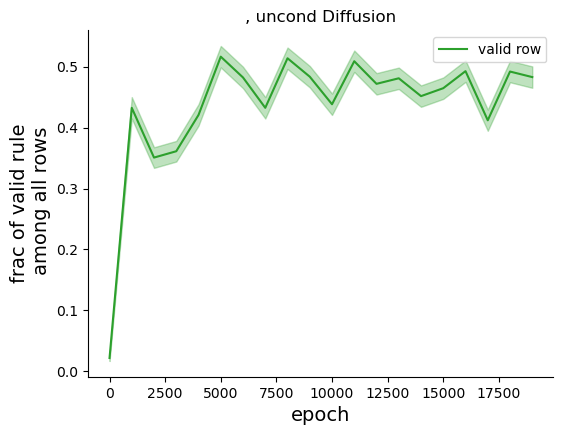

In [74]:
row_num = 3
title_str = ""

fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI(stats_df.valid_count, stats_df.sample_count * row_num, alpha=0.05)
shaded_error(plt.gca(), stats_df.epoch, stats_df.valid_count / stats_df.sample_count / row_num,
                CI_low, CI_high, label="valid row", color="C2")
ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title(f"{title_str}, uncond Diffusion")
ax.legend()

In [46]:
import einops
import pandas as pd
epoch_list = [1]+[*range(1000, 334000, 1000)]
stats_col = []
rule_list_all = []
consistency_all = []
pbar = tqdm(enumerate(epoch_list))
for i, epoch in pbar: 
    # print(i, epoch)
    sample_batch = sample_all[i] # [1024, 3, 9, 9]
    batchsize = sample_batch.shape[0]
    sample_batch = sample_batch.view(batchsize, 3, 3, 3, 9) # [1024, 3, 3, 9, 3]
    sample_batch = einops.rearrange(sample_batch, "B attr row h (panel w) -> B row panel (h w) attr", 
                                    panel=3, w=3, h=3, attr=3)
    # print(sample_batch.shape)
    r3_list, r2_list, rule_col = check_r3_r2_batch(sample_batch)
    # print(len(r3_list), len(r2_list))
    # count number of elements that are not empty
    r3_count = sum([len(x) > 0 for x in r3_list])
    r2_count = sum([len(x) > 0 for x in r2_list])
    rule_flatten = np.array(rule_col).flatten() # [3 * 1024]
    anyvalid_count = sum([len(x) > 0 for x in rule_flatten])
    stats_col.append({"epoch": epoch, "r3_count": r3_count, "r2_count": r2_count, 
                      "valid_count": anyvalid_count, "sample_count": batchsize})
    rule_list_all.append((rule_col))
    consistency_all.append((r3_list, r2_list))
    pbar.set_postfix({"r3_count": r3_count, "r2_count": r2_count})

stats_df = pd.DataFrame(stats_col)

0it [00:01, ?it/s, r3_count=0, r2_count=4]


ValueError: 

In [47]:
len(rule_col)

1024

In [43]:
stats_df["r3_ratio"] = stats_df["r3_count"] / sample_all[0].shape[0]
stats_df["r2_ratio"] = stats_df["r2_count"] / sample_all[0].shape[0]

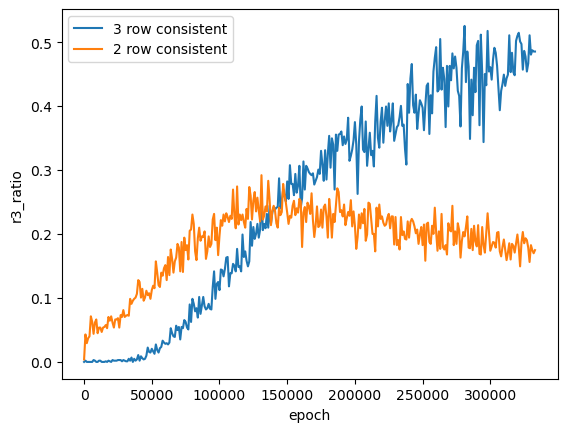

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=stats_df, x="epoch", y="r3_ratio", label="3 row consistent")
sns.lineplot(data=stats_df, x="epoch", y="r2_ratio", label="2 row consistent")
plt.show()

In [35]:
474 / 1024

0.462890625

In [24]:
len(r2_list)

1024

In [ ]:
attr_row = attr_tsr[:,3*i_row:3*(i_row+1),:] # torch.Size([3, 3, 9])
attr = einops.rearrange(attr_row, 'attr h (p w) -> p (h w) attr', h=3,w=3,p=3) # (3, 9, 3)
        

### checking real outcome

In [ ]:
import torch
import einops
train_attrs = torch.load('/n/home12/binxuwang/Github/DiffusionReasoning/train_inputs.pt')
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) attr -> c s attr H (pnl W)', H=3, W=3, attr=3, pnl=3)
train_row_img.shape

torch.Size([35, 10000, 3, 3, 9])

In [16]:
for i_rule in range(35): 
    attr = train_attrs[i_rule, 0]
    rule_list = check_row_rule(attr)
    print(rule_list)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[31]
[32]
[33]
[34]
[35]
[36]
[38]
[39]
